# Inter/intra observer variations

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tifffile as tiff
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import matplotlib.font_manager as fm
from matplotlib import cm
import matplotlib.font_manager as font_manager
import os
import re

In [2]:
#root = r'E:\BiAPoL\Shared\BiAPoLprojects\64_radiographic_workflow\Registration_user_study'
root = r'C:\Users\schnei17\Documents\PhD\Paper\Protonenradiografie\planning_study\Registration_user_study'
root_2 = r'C:\Users\schnei17\Documents\PhD\Paper\Protonenradiografie\planning_study\Data_Registration'

## Config

In [3]:
anonymize = True
save_figures = True

In [4]:
animals = os.listdir(root)

Let's write a function that helps us to parse the report file

In [5]:
def get_info(report_file: str):
    
    px_size_rg = 0.05
    px_size_xr = 0.1
    
    info = {}
    with open(report_file, 'rt') as file:
        for line in file:
            if 'Isocenter coordinates' in line:
                vals = re.findall(r'\d+\.\d+', line)
                info['isocenter_coords_x'] = float(vals[0]) * px_size_rg
                info['isocenter_coords_y'] = float(vals[1]) * px_size_rg
                
            if 'Target coordinates (radiography)' in line:
                vals = re.findall(r'\d+', line)
                info['target_coords_rg_x'] = float(vals[0]) * px_size_rg
                info['target_coords_rg_y'] = float(vals[1]) * px_size_rg
                
            if 'Target coordinates (plan)' in line:
                vals = re.findall(r'\d+', line)
                info['target_coords_xr_x'] = float(vals[0]) * px_size_xr
                info['target_coords_xr_y'] = float(vals[1]) * px_size_xr
                
            if 'Transformation parameters' in line:
                _line = line.split(':')[-1]
                val1 = re.findall(r'\d+\.\d+', _line)
                val2 = re.findall(r'\d+', ' '.join(_line.split(',')[-2:]))
                vals = val1 + val2
                info['trafo_r'] = float(vals[0])
                info['trafo_angle'] = float(vals[1])
                info['trafo_x'] = float(vals[1]) * px_size_rg
                info['trafo_y'] = float(vals[2]) * px_size_rg
                
            if 'Motor origin' in line:
                vals = re.findall(r'\d+\.\d+', line)
                info['motor_origin_x'] = float(vals[0])
                info['motor_origin_y'] = float(vals[1])
                
            if 'Motor destination' in line:
                vals = re.findall(r'\d+\.\d+', line)
                info['motor_dest_x'] = float(vals[0])
                info['motor_dest_y'] = float(vals[1])            
               
    return info

### Normalization

For better comparison acros mice, it is desirable to normalize the registration parameters by subtracting the mean of the respective vaue and animal. I.e., the motor destination coordinates of animal $X$ are calculated as 

$\text{Motor_destination}_X = \text{Motor_destination}_X - mean(\text{Motor_destination}_X)$

In [6]:
colums_to_normalize = ['isocenter_coords_x', 'isocenter_coords_y', 'target_coords_xr_x', 'target_coords_xr_y', 'target_coords_rg_x',
                       'target_coords_rg_y', 'motor_origin_x', 'motor_origin_y', 'motor_dest_x', 'motor_dest_y', 'trafo_angle', 'trafo_x', 'trafo_y']

Now, we collect all the data from the acquired log files. We put the results of all registration studies for a particular animal into a dictionary and stack these later-on.

In [7]:
results = []
for animal in animals:
    _results = []
    for study in os.listdir(os.path.join(root, animal)):
        observer = study.split('_')[1]
        
        
        report_file = os.path.join(root, animal, study, 'report.txt')
        info = get_info(report_file)
        
        data_columns = list(info.keys())

        info['observer'] = observer
        info['animal'] = animal
        
        _results.append(info)
    _df = pd.DataFrame(_results)
    results.append(_df)
df = pd.concat(results)

## Inter-observer variability

We first analyze inter-observer variability. For this, we remove occurrences of repeated registration of animals by single users. More precisely, if an observer repeated the registration of the ame animal multiple times, we keep only the results of the first registration.

In [8]:
inter_observer = df.drop_duplicates(subset = ['observer', 'animal'], keep='first').reset_index(drop=True)

# Normalize selected columns
for animal in animals:
    sub_df = inter_observer[inter_observer['animal'] == animal]
    inter_observer.loc[sub_df.index, colums_to_normalize] = sub_df[colums_to_normalize] - sub_df[colums_to_normalize].mean()
    
if anonymize:
    inter_observer['observer'] = 'Observer ' + pd.Series(pd.factorize(inter_observer['observer'])[0] + 1).astype(str)

#inter_observer

### Display target coordinates inter variability in radiographic image

calculate best/worst variability of target coordinates in radiography

In [11]:
dist = np.sqrt(inter_observer['target_coords_rg_x']**2 + inter_observer['target_coords_rg_y']**2)
dist_reshape = np.reshape(np.array(dist), (10, 3))
dist_mean = np.mean(dist_reshape, axis=1) 

max_dist = np.max(dist_mean)
max_dist_std = np.std(dist_reshape[np.argmax(dist_mean)])
max_mouse = animals[np.argmax(dist_mean)]
print(f'maximum distance variability: {max_dist} +/- {max_dist_std} mm for mouse {max_mouse}')

min_dist = np.min(dist_mean)
min_dist_std = np.std(dist_reshape[np.argmin(dist_mean)])
min_mouse = animals[np.argmin(dist_mean)]
print(f'minimum distance variability: {min_dist} +/- {min_dist_std} mm for mouse {min_mouse}')

global_mean = np.mean(dist_mean)
global_mean_std = np.std(dist_mean)
print(f'global mean distance variability: {global_mean} +/- {global_mean_std} mm')

maximum distance variability: 30.965006372795624 +/- 0.1659728875243254 mm for mouse P1_H_C3H_M54
minimum distance variability: 28.213357046466978 +/- 0.17743778789313852 mm for mouse P1_H_C3H_M46
global mean distance variability: 29.04103837719622 +/- 0.7846187044190366 mm


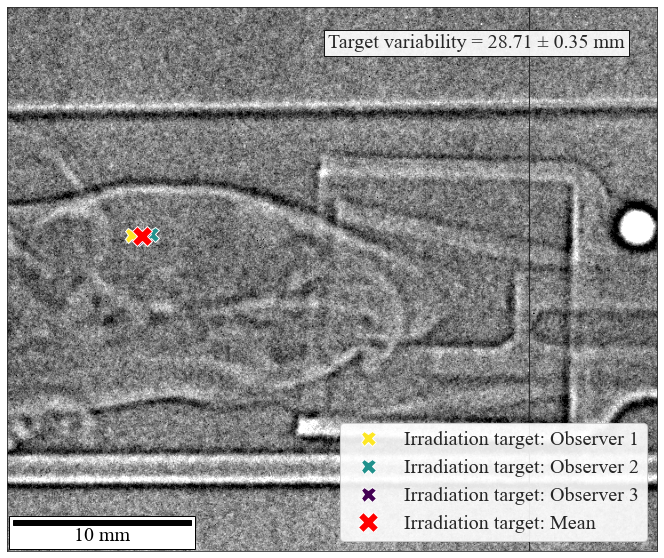

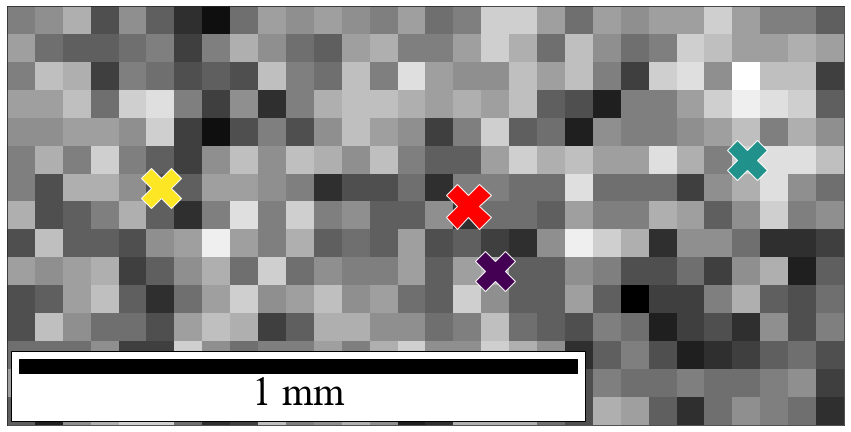

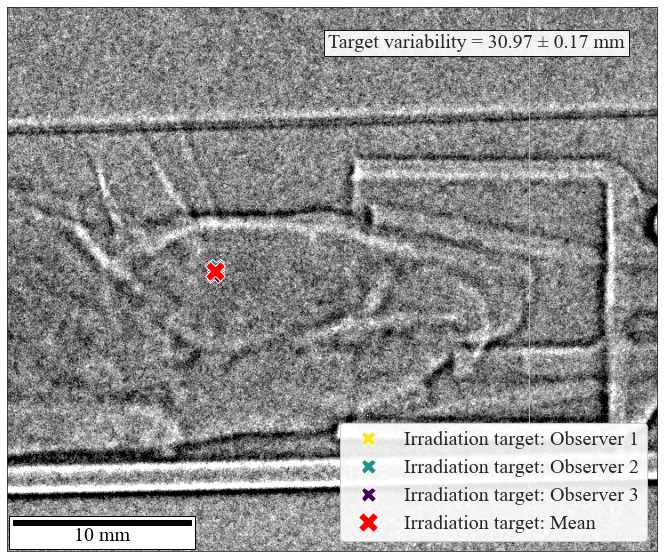

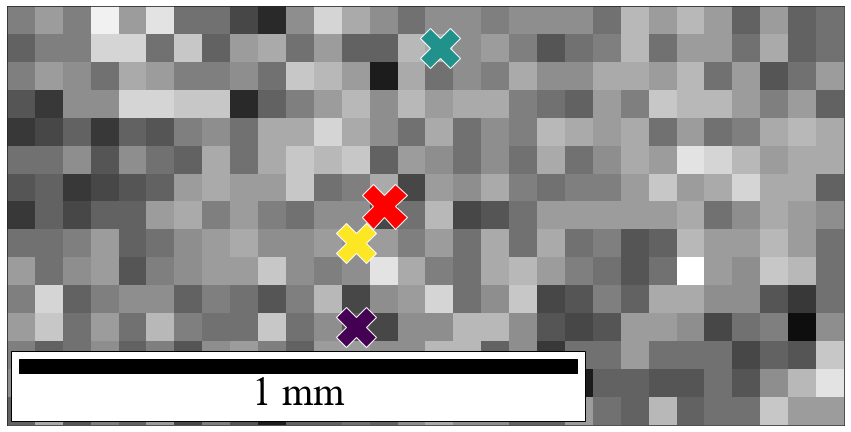

In [12]:
rg_max_mouse = tiff.imread(root_2 + '\\'  + 'P2E_M14' + '\\' + 'Maus14.tif')
rg_min_mouse = tiff.imread(root_2 + '\\'  + 'P1_H_C3H_M54' + '\\' + '20220405090035_MS54_35x20y.tif')

inter_observer = df.drop_duplicates(subset = ['observer', 'animal'], keep='first').reset_index(drop=True)
for animal in animals:
    sub_df = inter_observer[inter_observer['animal'] == animal]
    inter_observer.loc[sub_df.index, colums_to_normalize] = sub_df[colums_to_normalize]

x_rg_max = np.array(inter_observer['target_coords_rg_x'][8*3:8*3+3])
y_rg_max = np.array(inter_observer['target_coords_rg_y'][8*3:8*3+3])
x_rg_min = np.array(inter_observer['target_coords_rg_x'][5*3:5*3+3])
y_rg_min = np.array(inter_observer['target_coords_rg_y'][5*3:5*3+3])

sns.set_style("white")


idxes = [1,2,3]
cmap = plt.cm.get_cmap('viridis')
color=[cmap(0.9999999), cmap(0.5), cmap(0)]
font = font_manager.FontProperties(family='Times New Roman',
                                   weight='normal',
                                   style='normal', size=20)
font_1 = font_manager.FontProperties(family='Times New Roman',
                                   weight='normal',
                                   style='normal', size=40)
# max variability mouse radiography
fig, ax = plt.subplots(figsize = (15, 10))
ax.imshow(rg_max_mouse[400:,300:], origin='upper', cmap='gray_r', vmin=142, vmax=165)
#ax.set_title(f'Mouse {max_mouse} with highest variability')
for idx, x, y in zip(idxes, x_rg_max, y_rg_max):
    ax.plot(x/0.05-300, rg_max_mouse.shape[0]-y/0.05-400, marker='X', ms = 15, 
                  label=f'Irradiation target: Observer {idx}', linewidth=0, color=color[idx-1], markeredgecolor='white')
ax.plot(np.mean(x_rg_max/0.05-300), np.mean(rg_max_mouse.shape[0]-y_rg_max/0.05-400), marker='X', ms = 20, 
              label=f'Irradiation target: Mean', color='red', linewidth=0, markeredgecolor='white')
ax.legend(fontsize=14, loc = 'lower right', prop=font, framealpha=0.9)
ax.add_artist(AnchoredSizeBar(ax.transData, 200, '10 mm', 'lower left', 
                                  pad=0.2, color='black', frameon=True,
                                  size_vertical=5, fontproperties=font))
ax.text(0.95, 0.95, 'Target variability = {:.2f} \u00B1 {:.2f} mm'.format(dist_mean[8], np.std(dist_reshape[8])), transform=ax.transAxes, 
             horizontalalignment='right', verticalalignment='top', fontsize=14, 
             bbox={'facecolor': 'white', 'edgecolor': 'black', 'alpha': 0.9}, font=font)
plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[])
ax.figure.savefig(f'./figures/Target_variability_{max_mouse}')


# ZOOM max variability mouse radiography 
fig, ax = plt.subplots(figsize = (15, 10))
ax.imshow(rg_max_mouse[650:665,435:465], origin='upper', cmap='gray_r')
#ax.set_title(f'Mouse {max_mouse} with highest variability')
for idx, x, y in zip(idxes, x_rg_max, y_rg_max):
    ax.plot(x/0.05-435, rg_max_mouse.shape[0]-y/0.05-650, marker='X', ms = 40, linewidth=0, color=color[idx-1], 
            markeredgecolor='white')
ax.plot(np.mean(x_rg_max/0.05-435), np.mean(rg_min_mouse.shape[0]-y_rg_max/0.05-650), marker='X', ms = 45, color='red', 
              linewidth=0, markeredgecolor='white')
ax.add_artist(AnchoredSizeBar(ax.transData, 20, '1 mm', 'lower left', 
                                  pad=0.2, color='black', frameon=True,
                                  size_vertical=0.5, fontproperties=font_1))
plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[])
ax.figure.savefig(f'./figures/Target_variability_{max_mouse}_ZOOM')


# min variability mouse radiography
fig, ax = plt.subplots(figsize = (15, 10))
ax.imshow(rg_min_mouse[400:,300:], origin='upper', cmap='gray_r', vmin=32, vmax=50)
#ax.set_title(f'Mouse {min_mouse} with lowest variability')
for idx, x, y in zip(idxes, x_rg_min, y_rg_min):
    ax.plot(x/0.05-300, rg_min_mouse.shape[0]-y/0.05-400, marker='X', ms = 15, 
                  label=f'Irradiation target: Observer {idx}', linewidth=0, color=color[idx-1], markeredgecolor='white')
ax.plot(np.mean(x_rg_min/0.05-300), np.mean(rg_min_mouse.shape[0]-y_rg_min/0.05-400), marker='X', ms = 20, 
              label=f'Irradiation target: Mean', color='red', linewidth=0, markeredgecolor='white')
ax.legend(fontsize=14, loc = 'lower right', prop=font, framealpha=0.9)
ax.add_artist(AnchoredSizeBar(ax.transData, 200, '10 mm', 'lower left', 
                                  pad=0.2, color='black', frameon=True,
                                  size_vertical=5, fontproperties=font))
ax.text(0.95, 0.95, 'Target variability = {:.2f} \u00B1 {:.2f} mm'.format(dist_mean[5], np.std(dist_reshape[5])), transform=ax.transAxes, 
             horizontalalignment='right', verticalalignment='top', fontsize=14, 
             bbox={'facecolor': 'white', 'edgecolor': 'black', 'alpha': 0.9}, font=font)
plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[])
ax.figure.savefig(f'./figures/Target_variability_{min_mouse}')


# ZOOM min variability mouse radiography 
fig, ax = plt.subplots(figsize = (15, 10))
ax.imshow(rg_min_mouse[690:705,520:550], origin='upper', cmap='gray_r')
#ax.set_title(f'Mouse {min_mouse} with lowest variability')
for idx, x, y in zip(idxes, x_rg_min, y_rg_min):
    ax.plot(x/0.05-520, rg_min_mouse.shape[0]-y/0.05-690, marker='X', ms = 40, linewidth=0, color=color[idx-1], 
            markeredgecolor='white')
ax.plot(np.mean(x_rg_min/0.05-520), np.mean(rg_min_mouse.shape[0]-y_rg_min/0.05-690), marker='X', ms = 45, color='red', 
        linewidth=0, markeredgecolor='white')
ax.add_artist(AnchoredSizeBar(ax.transData, 20, '1 mm', 'lower left', pad=0.2, color='black', frameon=True,
                              size_vertical=0.5, fontproperties=font_1))
plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[])
ax.figure.savefig(f'./figures/Target_variability_{min_mouse}_ZOOM')




